# Modelo 2 -  Regresion. Calcular probabilidad de churn

In [23]:
import os
print("Current working directory:", os.getcwd())
os.chdir("C:\\Users\\kenda\\OneDrive\\CUC\\Cuatri_6\\BD\\IA\\Proyecto 1\ProyectoB_ChurnClientes-main\\ProyectoB_ChurnClientes-main\\models")
from imblearn.over_sampling import SMOTE
from tensorflow import random as tf_random
from tensorflow.keras.models import Sequential
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import random
import sys
import os
from src.data_prep import preprocesar

np.random.seed(7)
random.seed(7)
tf_random.set_seed(7)


full_df = pd.read_csv('../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')
full_df['TotalCharges'] = pd.to_numeric(full_df['TotalCharges'], errors='coerce')
full_df = full_df.dropna()
full_df = full_df.drop(columns='customerID')
full_df['SeniorCitizen'] = full_df['SeniorCitizen'].astype(str)

X_full = full_df.drop(columns='Churn')
y_full = full_df['Churn']

full_df.head(3)

Current working directory: C:\Users\kenda\OneDrive\CUC\Cuatri_6\BD\IA\Proyecto 1\ProyectoB_ChurnClientes-main\ProyectoB_ChurnClientes-main\models


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


## Prediccion

### Sin DropOut con class_weights

Se inicia probando el rendimiento del modelo eliminando las columnas con poca correlacion con la variable objetivo. Se utiliza la funcion sigmoid. Se realiza la pequeña prueba para verificar si realmente se genera una gran diferencia aplicando DropOut o no en este ejemplo

Epoch 1/200


C:\Users\kenda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7054 - loss: 0.5541 - recall: 0.7692 - val_accuracy: 0.7655 - val_loss: 0.5039 - val_recall: 0.7727
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7511 - loss: 0.5012 - recall: 0.7632 - val_accuracy: 0.7640 - val_loss: 0.4960 - val_recall: 0.7968
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7506 - loss: 0.4939 - recall: 0.7726 - val_accuracy: 0.7626 - val_loss: 0.4936 - val_recall: 0.7995
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7506 - loss: 0.4901 - recall: 0.7806 - val_accuracy: 0.7598 - val_loss: 0.4928 - val_recall: 0.7995
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7474 - loss: 0.4877 - recall: 0.7799 - val_accuracy: 0.7576 - val_loss: 0.4897 - val_recall: 0.8102
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7468 - loss: 0.4857 - recall: 0.7833 - val_accuracy: 0.7505 - val_loss: 0.4914 - val_recall: 0.8262
Epoch 7/200
88/88 ━━━━

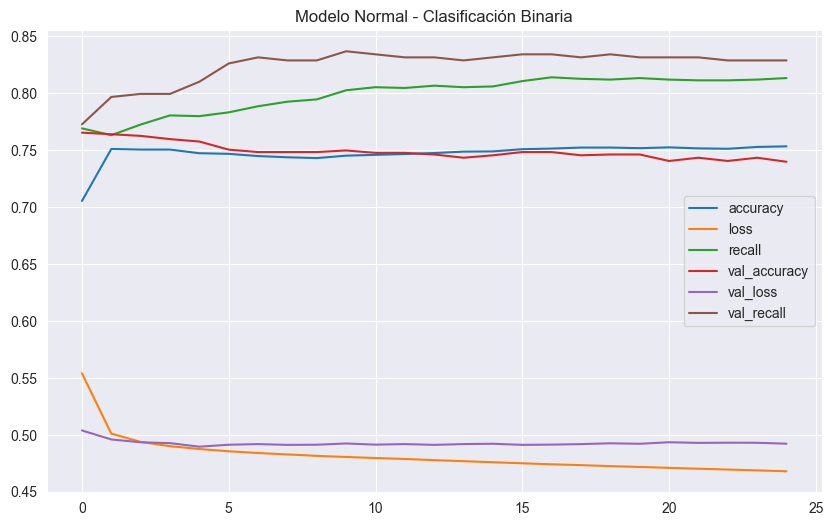

In [12]:
X_train, X_test, y_train, y_test, pipe = preprocesar(
    X_full.drop(columns=['MonthlyCharges', 'SeniorCitizen','Partner','Dependents','PaperlessBilling']),
    y_full
)
# Modelo Base Normal
model = Sequential()

model.add(Dense(units=X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=int(X_train.shape[1]/2), activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(
    optimizer="adam",
    loss='binary_crossentropy',
    metrics=['accuracy', Recall(name='recall')]
)

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

history_normal = model.fit(
    x=X_train,
    y=y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    verbose=1,
    callbacks=[early_stop]
)

pd.DataFrame(history_normal.history).plot(figsize=(10, 6))
plt.title('Modelo Normal - Clasificación Binaria')
plt.show()

In [13]:
predictions_prob = model.predict(X_test)
predictions = (predictions_prob >= 0.5).astype(int)

print(classification_report(y_test, predictions))

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1033
           1       0.51      0.83      0.63       374

    accuracy                           0.74      1407
   macro avg       0.71      0.77      0.71      1407
weighted avg       0.81      0.74      0.75      1407



### Usando Dropout

Epoch 1/200


C:\Users\kenda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6601 - loss: 0.6380 - recall: 0.5819 - val_accuracy: 0.7591 - val_loss: 0.5043 - val_recall: 0.7995
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7287 - loss: 0.5521 - recall: 0.7512 - val_accuracy: 0.7704 - val_loss: 0.4847 - val_recall: 0.7861
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7333 - loss: 0.5274 - recall: 0.7766 - val_accuracy: 0.7655 - val_loss: 0.4831 - val_recall: 0.7914
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7324 - loss: 0.5142 - recall: 0.7806 - val_accuracy: 0.7683 - val_loss: 0.4807 - val_recall: 0.7968
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7362 - loss: 0.5111 - recall: 0.8027 - val_accuracy: 0.7619 - val_loss: 0.4809 - val_recall: 0.7968
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7326 - loss: 0.5063 - recall: 0.7993 - val_accuracy: 0.7640 - val_loss: 0.4828 - val_recall: 0.7941
Epoch 7/200
88/88 ━━━━

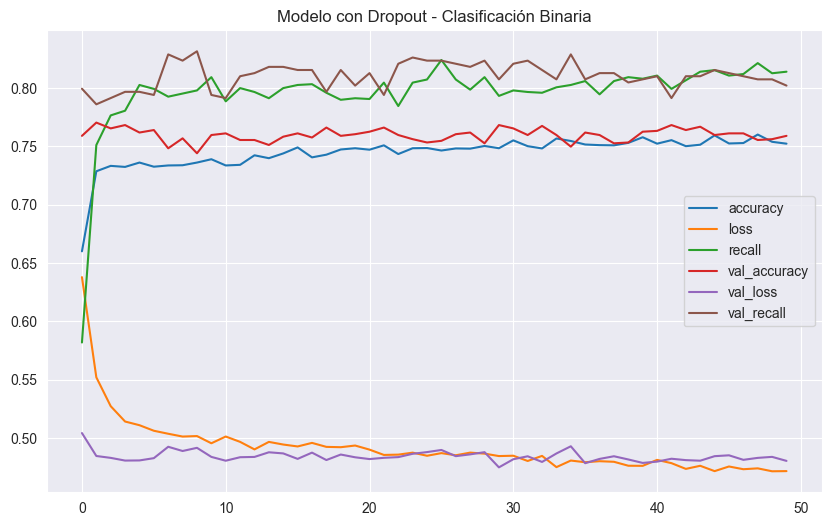

In [14]:
# Modelo con Dropout
model = Sequential()

model.add(Dense(units=X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(units=int(X_train.shape[1]/2), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(
    optimizer="adam",
    loss='binary_crossentropy',
    metrics=['accuracy', Recall(name='recall')]
)

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

history_dropout = model.fit(
    x=X_train,
    y=y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    verbose=1,
    callbacks=[early_stop]
)

pd.DataFrame(history_dropout.history).plot(figsize=(10, 6))
plt.title('Modelo con Dropout - Clasificación Binaria')
plt.show()

In [32]:
predictions_prob = model.predict(X_test)
predictions = (predictions_prob >= 0.5).astype(int)

print(classification_report(y_test, predictions))

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step
              precision    recall  f1-score   support

           0       0.92      0.75      0.83      1033
           1       0.54      0.81      0.65       374

    accuracy                           0.77      1407
   macro avg       0.73      0.78      0.74      1407
weighted avg       0.82      0.77      0.78      1407



Al usar un Dropout se obtienen resultados muy similares, dando a entender que para este caso el cambio es minimo, el ajuste de las predicciones pueden ir mas de la mano de las correlacion no tan altas

### Modelo con SMOTE

Epoch 1/200


C:\Users\kenda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6417 - recall: 0.4475 - val_loss: 0.5293 - val_recall: 0.8128
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5438 - recall: 0.7692 - val_loss: 0.4957 - val_recall: 0.8182
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5256 - recall: 0.7793 - val_loss: 0.4946 - val_recall: 0.8235
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5184 - recall: 0.7826 - val_loss: 0.4886 - val_recall: 0.8128
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5041 - recall: 0.7833 - val_loss: 0.4908 - val_recall: 0.8182
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5047 - recall: 0.7993 - val_loss: 0.4944 - val_recall: 0.8289
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4975 - recall: 0.7940 - val_loss: 0.4908 - val_recall: 0.8369
Epoch 8/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4986 - recall: 0.8033 - val_loss: 0.4897 - val_recall: 0.8262
Epoch 9/200
88/88 ━━━━━━━━━━

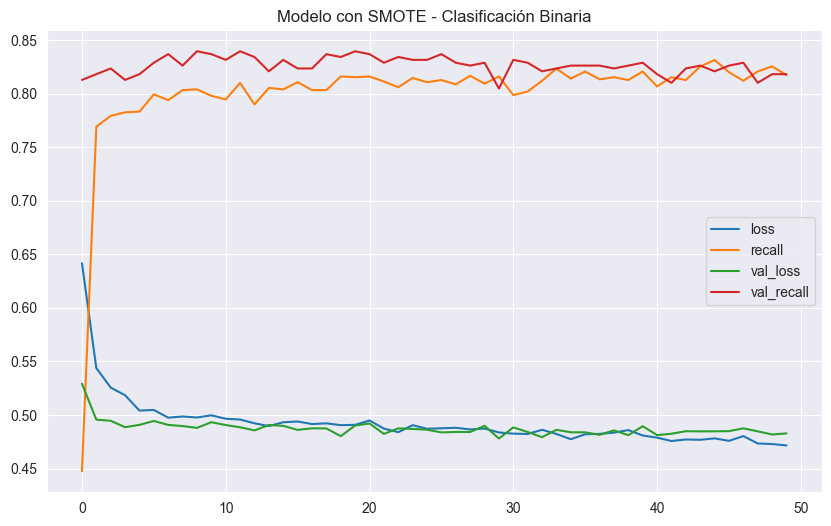

In [24]:
# Modelo con SMOTE
sm = SMOTE(random_state=7)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
model = Sequential()

model.add(Dense(units=X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(units=int(X_train.shape[1]/2), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=[Recall(name='recall')])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

history_dropout = model.fit(
    x=X_train,
    y=y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    verbose=1,
    callbacks=[early_stop]
)

pd.DataFrame(history_dropout.history).plot(figsize=(10, 6))
plt.title('Modelo con SMOTE - Clasificación Binaria')
plt.show()

In [25]:
predictions_prob = model.predict(X_test)
predictions = (predictions_prob >= 0.5).astype(int)

print(classification_report(y_test, predictions))

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1033
           1       0.52      0.82      0.63       374

    accuracy                           0.75      1407
   macro avg       0.72      0.77      0.72      1407
weighted avg       0.81      0.75      0.76      1407



Al usar un SMOTE se obtienen resultados muy similares, dando a entender que para este caso el cambio es minimo

## Evaluacion final

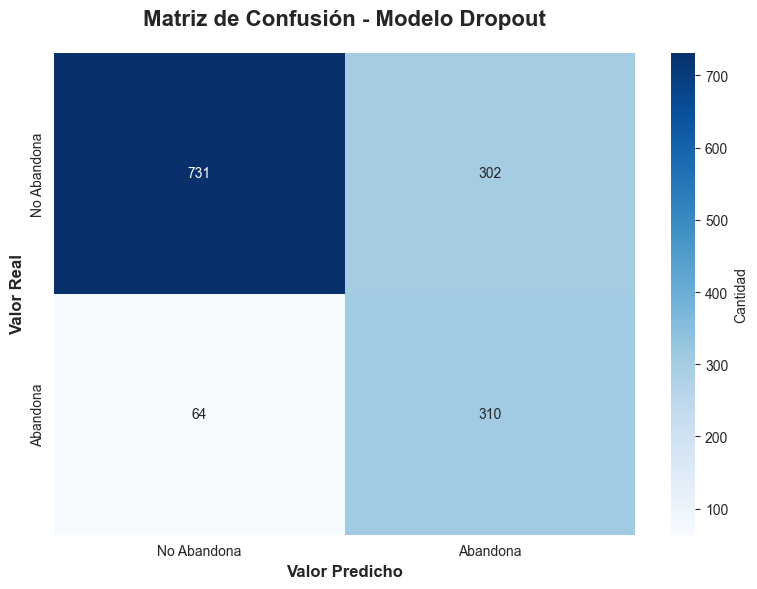

In [15]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Abandona', 'Abandona'],
            yticklabels=['No Abandona', 'Abandona'],
            cbar_kws={'label': 'Cantidad'})

plt.title('Matriz de Confusión - Modelo Dropout', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Valor Real', fontsize=12, fontweight='bold')
plt.xlabel('Valor Predicho', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


Como se observa el caso la mayoria de personas que aperecen como no es mas acertado pero el si se mantiene como un 50% aciertos

## Exportar csv y modelos

In [20]:
train_df = pd.concat((X_train, y_train), axis=1)
test_df = pd.concat((X_test, y_test), axis=1)

#Sustituir booleanos
for df in [train_df, test_df]:
    df['Churn'] = df['Churn'].map({0: 'No', 1: 'Yes'})

train_df.to_csv('../data/processed/train-Modelo-1.csv', index=False)
test_df.to_csv('../data/processed/test-Modelo-1.csv', index=False)


In [21]:
model.save('../models/model1.keras')